In [1]:
import numpy as np
import pandas as pd
import cv2

from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
path_metrics = Path(r'C:\Users\Tim\Documents\GitHub\Study\X-ray\xray\data\pipeline\metrics\metrics_annotations_1.pickle')
path_labels = Path(r'C:\Users\Tim\Documents\GitHub\Study\X-ray\xray\data\xray_dataset\annotations_1\labels_good_bad.pickle')

with open(path_metrics, 'rb') as file:
    metrics = pickle.load(file)

with open(path_labels, 'rb') as file:
    labels = pickle.load(file)
    
print('len(metrics) {}, len(labels) {}'.format(len(metrics), len(labels)))
    
    
metrics_data = []

for name, label in labels.items():
    metric = metrics.get(name)
    if not metric:
        continue
    metric.append(label)
    metrics_data.append(metric)
    
metrics_data = np.array(metrics_data)


df = pd.DataFrame(metrics_data, columns=['iou', 'cos', 'ar', 'iou_d', 'cos_d', 'ar_d', 'label'])
# df = df[['iou', 's', 'label']]

df['label'] = df['label'].astype(int)

print('shape: {}'.format(df.shape))
display(df.head())


X = df.drop('label', axis=1).to_numpy()
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# X_train = X
# y_train = y

len(metrics) 1135, len(labels) 950
shape: (950, 7)


,iou,cos,ar,iou_d,cos_d,ar_d,label
0,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0
1,0.273611,0.460723,0.032573,0.443412,0.638703,0.018668,0
2,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,1
3,0.180346,0.305840,0.000424,0.332880,0.500042,0.000552,1
4,0.021401,0.041905,0.000008,0.119668,0.213771,0.000034,0


In [3]:
# plt.scatter(X[:, 0], X[:, 1]);

In [4]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 30),
}

clf = LogisticRegression(solver='liblinear')
clf = GridSearchCV(clf, param_grid, cv=4, n_jobs=-1)
best_model = clf.fit(X, y)

regr = best_model.best_estimator_
regr.get_params()

{'C': 62.10169418915616,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [5]:
path_save_model = Path('xray/data/models/regr.pickle')

with open(path_save_model, 'wb') as file:
    pickle.dump(regr, file)

In [6]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 4, 1),
    'min_samples_split': np.arange(2, 200, 10),
    'min_samples_leaf': np.arange(4, 200, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
}

clf = DecisionTreeClassifier()
clf = GridSearchCV(clf, param_grid, cv=4, n_jobs=-1)
best_model = clf.fit(X, y)

tree = best_model.best_estimator_
tree.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 14,
 'min_samples_split': 92,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

LogisticRegression - score_train: 0.807, score_test: 0.758
Test confusion matrix:


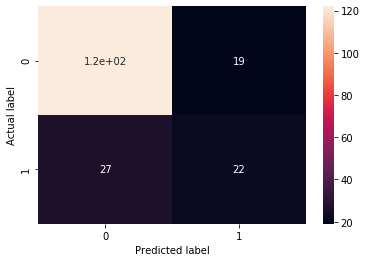

DecisionTreeClassifier - score_train: 0.817, score_test: 0.753
Test confusion matrix:


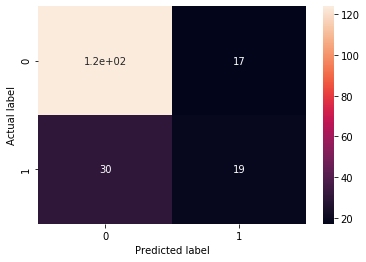

In [7]:
models = {
    'LogisticRegression': regr,
    'DecisionTreeClassifier': tree,
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    
    preds = model.predict(X_train)
    cm_train = sklearn.metrics.confusion_matrix(y_train, preds)
    preds = model.predict(X_test)
    cm_test = sklearn.metrics.confusion_matrix(y_test, preds)
    
    print('{} - score_train: {:.3f}, score_test: {:.3f}'.format(model_name, score_train, score_test))
    
    print('Test confusion matrix:')
    sns.heatmap(cm_test, annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

Logistic regression coefs:


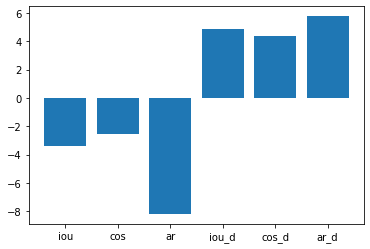

In [8]:
print('Logistic regression coefs:')
plt.bar(range(regr.coef_.shape[1]), regr.coef_[0]);
plt.xticks(range(regr.coef_.shape[1]), df.columns[:-1]);

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


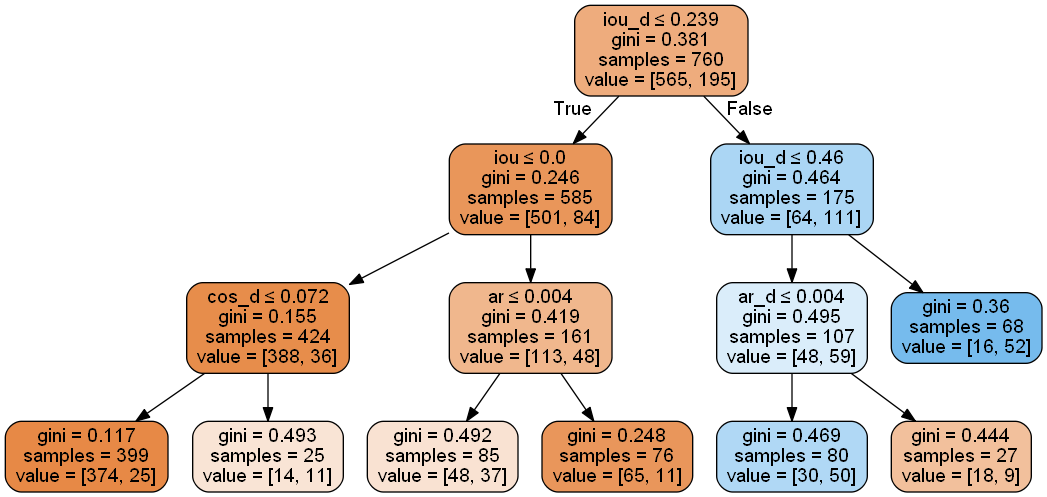

In [9]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=df.columns[:-1])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())